**Tanmaya Sangwan**

In [ ]:
#importing libraries
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
import torch
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering

In [ ]:
!pip3 install transformers[torch]

     |████████████████████████████████| 3.1 MB 9.8 MB/s 
     |████████████████████████████████| 3.3 MB 39.6 MB/s 
     |████████████████████████████████| 596 kB 40.0 MB/s 
     |████████████████████████████████| 895 kB 58.3 MB/s 
     |████████████████████████████████| 59 kB 6.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#LOADING THE DATASET
import pandas as pd
df = pd.DataFrame(columns=['Text','Label'])
with open("/content/assignment_4.txt", "r",encoding = "ISO-8859-1") as fin:
    for line in fin:
        text, label = line.strip().rsplit("@", 1)
        label = label.lstrip()
        d = {'Text': text, 'Label': label}
        ser = pd.Series(data=d)
        df = df.append(d, ignore_index=True)


**a. Computing the text embeddings for each text in the data**

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
embedder = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
embedder.eval()
batch_size = 1
sentences = df['Text']
text_embedding = []
for idx in range(0, len(sentences), batch_size):
    batch = sentences[idx : min(len(sentences), idx+batch_size)]
    encoded = tokenizer.batch_encode_plus(batch,max_length=50, padding='max_length', truncation=True)
for idx in range(0, len(sentences), batch_size):
    batch = sentences[idx : min(len(sentences), idx+batch_size)]
    encoded = {key:torch.LongTensor(value) for key, value in encoded.items()}
    with torch.no_grad():
        outputs = embedder(**encoded)
    t = outputs.last_hidden_state[0][0].numpy()
    text_embedding.append(t)
print(len(text_embedding))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2264


**b Using sklearn’s Agglomerative Clustering on the BERT embeddings.**

In [ ]:
X = np.array(text_embedding)
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X)

**c Writing a function to create the dendogram of clusters**

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


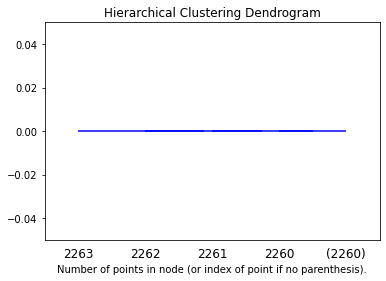

In [ ]:
#Creating dendogram function for 3C
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()



**d Creating a t-SNE projection**

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


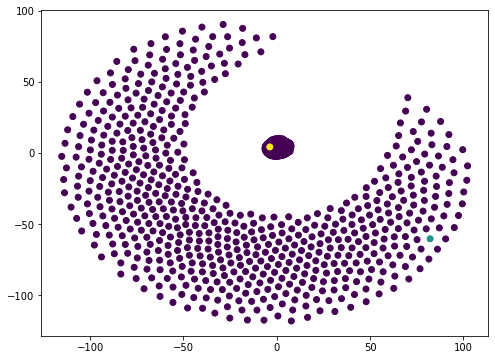

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components =2)
proj_embedding = tsne.fit_transform(X)

import matplotlib.pyplot as plt
plt.figure(figsize =(8,6))
plt.scatter(x = proj_embedding[:,0], y=proj_embedding[:,1], c = prediction_labels)
plt.show()

**It looks like the clusters are clearly separated**

**e computing centroid of largest cluster and printing original text of 5 instances closest to the centroid**

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(n_clusters=3)
model = model.fit(X)
prediction_labels = model.labels_
large = [index for index,value in enumerate(prediction_labels) if value ==2]
centroid = X[large, :].mean(axis=0)

def cosine_sim(a, b):
    a = np.linalg.norm(a)
    b = np.linalg.norm(b)
    cos = np.dot(a,b)/(a*b)
    return cos
cos_list = []
for embed in X:
    cos_list.append(cosine_sim(centroid, embed))
top5 = np.argsort(np.array(cos_list))[-5:]
#printing original text of the 5 instances closest to the centroid.
for index,i in enumerate(top5):
    print(index, " ", df['Text'][i])


0   According to an  posted by the World Intellectual Property Organization : `` The present invention relates to hydrocarbons and particularly to the manufacture of hydrocarbon components suitable as aviation fuels or jet fuels and as blending stocks for aviation fuels .
1   And that 's exactly what happened on a recent weekday when an East Haven baker was brought in to remind residents about the Easter tradition of making wheat and rice pies .
2   Any investment or investment activity to which this communication relates is only available to relevant persons and will be engaged in only with relevant persons .
3   Mika Stahlberg , VP F-Secure Labs , said , `` We are excited and proud that F-Secure has been recognized by AV-Comparatives as the Product of the Year .
4   Sales in Finland decreased by 10.5 % in January , while sales outside Finland dropped by 17 % .


***I don''t think there is a truly common theme between the texts. however, I suggest that theme that groups them together is repeating words in the text, certain words are repating more than once in each sentence, except for the 2nd one***